# Basic Concepts

Introduction to systematic/algorithmic trading.

## Russell 2000 Index

In [1]:
import os
import sys
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import linregress

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

# Define the path to the /src directory
src_path = os.path.abspath(os.path.join('..', 'src'))

# Check if the path is already in sys.path to avoid duplication
if src_path not in sys.path:
    sys.path.append(src_path)

from modules.portfolio import sharpe_ratio

In [2]:
rut_df = pd.read_csv('../mock_data/RUT.csv', index_col='Date', parse_dates=True)

<Axes: title={'center': 'Adjusted Close of Russell 2000 Index'}, xlabel='Date'>

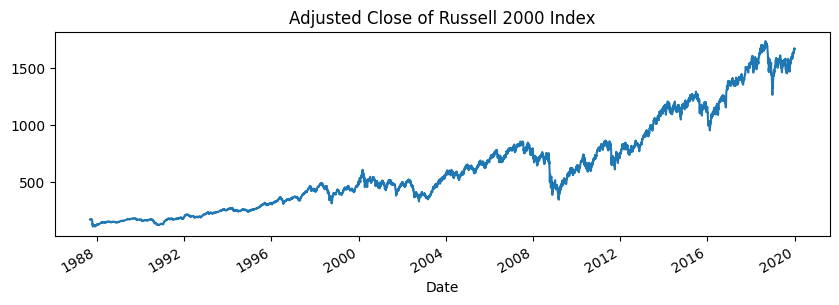

In [3]:
plt.figure(figsize=(10,3), dpi=100)
plt.title("Adjusted Close of Russell 2000 Index")
rut_df['Adj Close'].plot(kind='line')

## Sharpe Ratio

- The Sharpe Ratio is a measure used to assess the risk-adjusted return of an investment or portfolio.
- It indicates how much excess return is received for the extra volatility (risk) endured by holding a risky asset compared to a risk-free asset.
- **Formula**
  - $\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$
- **Where**:
  - $R_p$ = Return of the portfolio or investment
  - $R_f$ = Risk-free rate (return of a risk-free asset, like government bonds)
  - $\sigma_p$ = Standard deviation of the portfolio’s excess return (a measure of risk)
- **Interpretation**
  - **Sharpe Ratio > 1**: Indicates a good risk-adjusted return.
  - **Sharpe Ratio = 1**: Indicates an acceptable risk-adjusted return (S&P 500)
  - **Sharpe Ratio < 1**: Indicates a poor risk-adjusted return.
  - Higher Sharpe Ratios (>2) are preferred as they imply better risk-adjusted performance.
- **Limitations**
  - **Assumes Normal Distribution**: The Sharpe Ratio assumes that returns are normally distributed, which may not always be the case.
  - **Ignores Skewness and Kurtosis**: It does not account for the potential for extreme events (tail risks) in the distribution of returns.
  - **Static Measure**: It is a snapshot and does not account for changes in risk or market conditions over time.

In [4]:
rut_df['Daily Return'] = rut_df['Adj Close'].pct_change(1)
rut_df = rut_df.dropna() # drops first row where Daily Return is NaN

In [5]:
rut_std = rut_df['Daily Return'].std()

In [6]:
def compute_sharpe_ratio(
    df,
    daily_return_column="Daily Return",
    risk_free_rate: float = 0.0,
    is_annual_ratio: bool = True,
):

    mean_return = df[daily_return_column].mean()
    std = rut_df[daily_return_column].std()

    sharpe_ratio = (mean_return - risk_free_rate) / std

    return sharpe_ratio * (252 ** 0.5) if is_annual_ratio else sharpe_ratio


compute_sharpe_ratio(rut_df)

0.4507934255302507

## Sortino Ratio

- The Sortino Ratio is a performance measurement tool used to evaluate the risk-adjusted return of an investment or portfolio.
- Unlike the Sharpe Ratio, which considers both upside and downside volatility, the Sortino Ratio focuses specifically on downside risk, providing a clearer view of the investment's performance in adverse conditions.
- **Formula**
  - $\text{Sortino Ratio} = \frac{R_p - R_t}{\sigma_d}$
- **Where:**
  - $R_p$ = Return of the portfolio or investment
  - $R_t$ = Target return (usually the risk-free rate or a minimum acceptable return)
  - $\sigma_d$ = Downside deviation (standard deviation of negative returns)
- **Interpretation**
  - **Sortino Ratio > 1**: Indicates good risk-adjusted performance considering downside risk.
  - **Sortino Ratio = 1**: Indicates an acceptable level of risk-adjusted return.
  - **Sortino Ratio < 1**: Indicates poor performance when factoring in downside risk.
  - Higher Sortino Ratios (>2) are preferred as they imply better performance relative to the risk of negative returns.
- **Advantages**
  - **Focus on Downside Risk**: By measuring only downside volatility, it provides a more accurate picture of risk for risk-averse investors.
  - **Target Return Flexibility**: Allows investors to set their own target return, making it adaptable to individual investment goals.
- **Limitations**
  - **Requires More Data**: Calculation of downside deviation requires historical return data and can be complex.
  - **Target Dependency**: The choice of the target return can significantly influence the Sortino Ratio, making comparisons across different investments potentially misleading.
  - **Ignores Upside Potential**: By focusing solely on downside risk, it may overlook positive performance in volatile markets.

In [7]:
def compute_sortino_ratio(
    df,
    daily_return_column="Daily Return",
    threshold: float=0.0,
    risk_free_rate: float = 0.0,
    is_annual_ratio: bool = True,
):

    mean_return = df[daily_return_column].mean()
    downside_std = df[df[daily_return_column] < threshold][daily_return_column].std() # only returns below threshold

    sharpe_ratio = (mean_return - risk_free_rate) / downside_std

    return sharpe_ratio * (252 ** 0.5) if is_annual_ratio else sharpe_ratio


compute_sortino_ratio(rut_df)

0.570034198159496

## Probabilistic Sharpe Ratio

- The Probabilistic Sharpe Ratio (PSR) is an enhanced version of the traditional Sharpe Ratio.
- It aims to determine whether the observed Sharpe Ratio is statistically significant or likely to have occurred by chance.
- The PSR accounts for variability and adjusts for the bias that arises when evaluating multiple strategies or periods.
- Assesses the likelihood that a given Sharpe Ratio is a genuine measure of risk-adjusted performance rather than a random occurrence due to variability in returns.
- **Formula**
  - $\widehat{PSR}(SR^{*}) = P\left(\widehat{SR} > SR^{*}\right) = Z\left(\frac{(\widehat{SR} - SR^{\ast})\sqrt{n-1}}{\sqrt{1 - \hat{\gamma}_{3}\widehat{SR} + \frac{\hat{\gamma}_{4}-1}{4}\widehat{SR}^{2}}}\right)$
- **Where**:
    - $\widehat{SR}$ = Observed Sharpe Ratio
    - $SR^*$ = Benchmark Sharpe Ratio (a Sharpe Ratio threshold considered to be acceptable, e.g. 0)
    - $n$ = Number of observations
    - $Z$ = Cumulative distribution function (CDF) of a standard normal distribution
    - $\hat{\gamma}_{3}$ is the observed skewness of the returns
    - $\hat{\gamma}_{4}$ is the observed kurtosis of the returns
- **Interpretation**
  - The PSR outputs a probability value between 0 and 1:
    - **PSR close to 1**: High confidence that the observed Sharpe Ratio exceeds the benchmark and is statistically significant.
    - **PSR close to 0**: Low confidence that the observed Sharpe Ratio is genuinely higher than the benchmark.
  - A higher PSR suggests that the Sharpe Ratio is not due to randomness and is more likely to reflect actual risk-adjusted performance.
- **Advantages**
  - **Adjusts for Bias**: Accounts for the selection bias inherent in choosing multiple strategies based on their high Sharpe Ratios.
  - **More Reliable**: Provides a probabilistic interpretation, making it easier to quantify the confidence in an observed Sharpe Ratio.
- **Limitations**
  - **Complexity**: The PSR is more complex to calculate and interpret than the traditional Sharpe Ratio.
  - **Assumption of Normality**: Similar to the Sharpe Ratio, the PSR assumes that returns are normally distributed, which may not always be true.
  - **Dependence on Benchmark**: The choice of $SR^*$ as the benchmark Sharpe Ratio can significantly affect the interpretation of the PSR.

In [8]:
def compute_probabilistic_sharpe_ratio(
    df,
    daily_return_column='Daily Return',
    risk_free_rate: float = 0.0,
    benchmark_sharpe_ratio: float = 0.0,
    is_annual_ratio: bool = True,
):

    daily_observed_sharpe_ratio = compute_sharpe_ratio(df, daily_return_column, risk_free_rate, is_annual_ratio=False)
    skew = scipy.stats.skew(df[daily_return_column])
    kurtosis = scipy.stats.kurtosis(df[daily_return_column], fisher=False)
    n = len(df)

    numerator = ((daily_observed_sharpe_ratio - benchmark_sharpe_ratio) * (n - 1) ** 0.5)
    denominator = (1 - skew * daily_observed_sharpe_ratio + ((kurtosis - 1) / 4) * (daily_observed_sharpe_ratio ** 2) ) ** 0.5

    probabilistic_sharpe_ratio = scipy.stats.norm.cdf(numerator / denominator)

    return probabilistic_sharpe_ratio * (252 ** 0.5) if is_annual_ratio else probabilistic_sharpe_ratio


compute_probabilistic_sharpe_ratio(rut_df, is_annual_ratio=False)

0.9945474914938986

In [9]:
# compare with src code
sharpe_ratio.probabilistic_sharpe_ratio(rut_df['Daily Return'])

0.9945474914938986

## Portfolio Optimisation


In [10]:
cost_df = pd.read_csv('../mock_data/COST.csv', index_col='Date', parse_dates=True)['Adj Close']
wmt_df = pd.read_csv('../mock_data/WMT.csv', index_col='Date', parse_dates=True)['Adj Close']
tgt_df = pd.read_csv('../mock_data/TGT.csv', index_col='Date', parse_dates=True)['Adj Close']
dg_df = pd.read_csv('../mock_data/DG.csv', index_col='Date', parse_dates=True)['Adj Close']

In [11]:
retail_df = pd.concat([cost_df, wmt_df, tgt_df, dg_df], axis=1)
retail_df.columns = ['COST', 'WMT', 'TGT', 'DG']
retail_df

,COST,WMT,TGT,DG
Date,,,,
2016-09-06,140.896622,65.758080,60.674061,68.342621
2016-09-07,138.739395,64.911324,60.847187,68.105331
2016-09-08,136.805038,64.704163,60.120117,67.080215
2016-09-09,134.335831,63.325943,59.721989,66.994766
2016-09-12,135.218338,64.803238,59.981625,68.366478
...,...,...,...,...
2021-08-27,450.339996,146.520004,249.179993,225.250000
2021-08-30,455.929993,147.699997,249.360001,225.360001
2021-08-31,455.489990,148.100006,246.979996,222.910004


<Axes: xlabel='Date'>

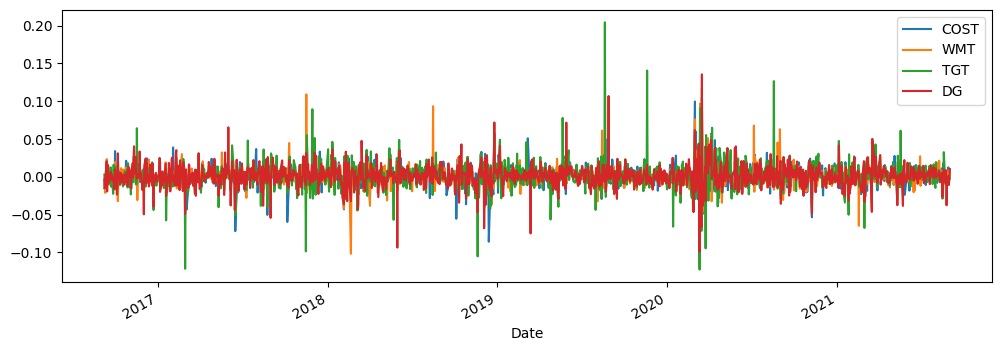

In [12]:
retail_daily_returns_df = retail_df.pct_change(1).dropna()
retail_daily_returns_df.plot(figsize=(12,4))

<Axes: xlabel='Date'>

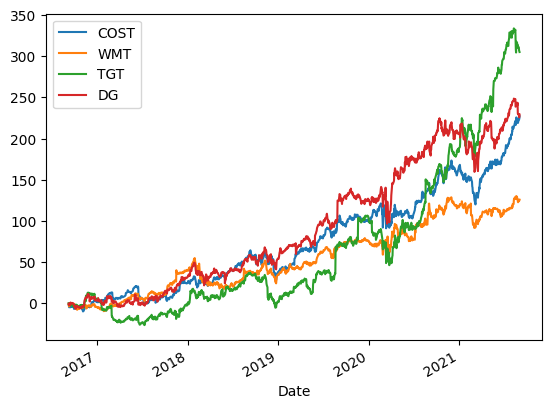

In [13]:
retail_cumulative_returns_df = ((1 + retail_daily_returns_df).cumprod() - 1) * 100
retail_cumulative_returns_df.plot()

[0.25, 0.25, 0.25, 0.25]


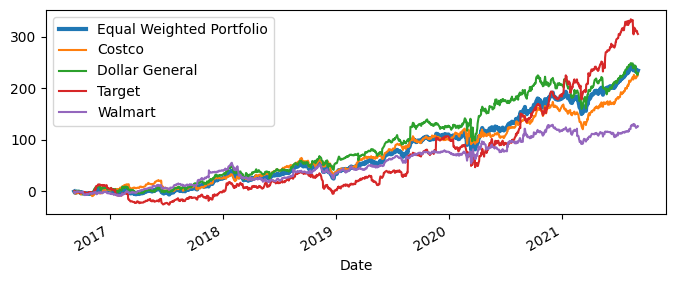

In [14]:
n = len(retail_cumulative_returns_df.columns)
equal_weightings = n * [1 / n]
print(equal_weightings)
retail_weighted_daily_returns = np.dot(equal_weightings, retail_daily_returns_df.transpose())
retail_weighted_cumulative_returns = ((1 + retail_weighted_daily_returns).cumprod()-1) * 100 # np.dot([a, b], [x, y]) => a * x + b * y
retail_weighted_cumulative_returns_series = pd.Series(retail_weighted_cumulative_returns, index=retail_daily_returns_df.index)

plt.figure(figsize=(8,3))
retail_weighted_cumulative_returns_series.plot(label="Equal Weighted Portfolio", linewidth=3)
retail_cumulative_returns_df['COST'].plot(label="Costco")
retail_cumulative_returns_df['DG'].plot(label="Dollar General")
retail_cumulative_returns_df['TGT'].plot(label="Target")
retail_cumulative_returns_df['WMT'].plot(label="Walmart")
plt.legend()

### Monte Carlo Simulation for Portfolio Optimisation

In [15]:
log_returns_df = np.log(retail_df / retail_df.shift(1)) # logarithmic return
log_returns_df.head()

,COST,WMT,TGT,DG
Date,,,,
2016-09-06,NaN,NaN,NaN,NaN
2016-09-07,-0.015429,-0.012960,0.002849,-0.003478
2016-09-08,-0.014040,-0.003197,-0.012021,-0.015166
2016-09-09,-0.018214,-0.021530,-0.006644,-0.001275
2016-09-12,0.006548,0.023060,0.004338,0.020268


In [16]:
N = len(retail_df.columns)

def generate_weights(n):
    weights = np.random.random(n)
    return weights / np.sum(weights)

generate_weights(N)

array([0.11579362, 0.28853806, 0.38287474, 0.21279359])

In [17]:
def calculate_returns(weights, log_returns):
    # average daily return
    return np.sum(log_returns.mean() * weights) * 252 # annual return

calculate_returns(generate_weights(N), log_returns_df)

0.20611718000036153

In [18]:
def calculate_volatility(weights, log_returns_covariance):
    ## annualised version of covariance matrix
    annualised_covariance = np.dot(log_returns_covariance * 252, weights)
    vol = np.dot(weights.transpose(), annualised_covariance)
    return np.sqrt(vol)
calculate_volatility(generate_weights(N), log_returns_df.cov())

0.19314025833849155

In [19]:
monte_carlo_portfolio_returns = []
monte_carlo_portfolio_vol = []
monte_carlo_portfolio_weights = []

for simulation in range(6000):
    weights = generate_weights(N)
    monte_carlo_portfolio_weights.append(weights)
    
    simulation_returns = calculate_returns(weights, log_returns_df)
    monte_carlo_portfolio_returns.append(simulation_returns)

    simulation_vol = calculate_volatility(weights, log_returns_df.cov())
    monte_carlo_portfolio_vol.append(simulation_vol)

len(monte_carlo_portfolio_returns)

6000

Text(0, 0.5, 'Returns')

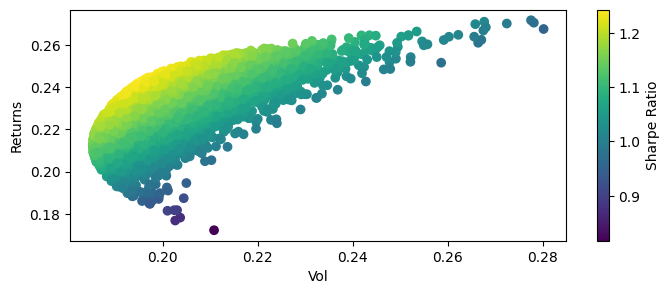

In [20]:
monte_carlo_portfolio_sharpe_ratios = np.array(monte_carlo_portfolio_returns) / np.array(monte_carlo_portfolio_vol)

plt.figure(figsize=(8,3))
plt.scatter(monte_carlo_portfolio_vol, monte_carlo_portfolio_returns,c=monte_carlo_portfolio_sharpe_ratios)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Vol")
plt.ylabel("Returns")

In [21]:
monte_carlo_highest_weightings = monte_carlo_portfolio_weights[np.argmax(monte_carlo_portfolio_sharpe_ratios)]
for i in range(N):
    print(f"{retail_df.columns[i]} weighting: {monte_carlo_highest_weightings[i]}")

COST weighting: 0.5376387589875777
WMT weighting: 0.004286377663718984
TGT weighting: 0.16071047908538424
DG weighting: 0.29736438426331896


### Minimization Search for Portfolio Optimisation

In [22]:
def func_to_minimize(weights):
    # find the minimum value of the negative Sharpe ratios (SR * -1)
    return (
        calculate_returns(weights, log_returns_df)
        / calculate_volatility(weights, log_returns_df.cov())
    ) * -1

In [23]:
equal_weightings
sum_constraint = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for n in range(N))
bounds # weights are between 0 and 1

((0, 1), (0, 1), (0, 1), (0, 1))

In [24]:
optimised_weightings = minimize(fun=func_to_minimize, x0=equal_weightings, bounds=bounds, constraints=sum_constraint)

print(optimised_weightings)

for i in range(N):
    print(f"{retail_df.columns[i]} weighting: {optimised_weightings['x'][i]:.3f}")

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.2451267776112656
       x: [ 5.846e-01  5.638e-18  1.768e-01  2.386e-01]
     nit: 4
     jac: [-3.517e-04  5.834e-02  1.120e-03  3.204e-05]
    nfev: 20
    njev: 4
COST weighting: 0.585
WMT weighting: 0.000
TGT weighting: 0.177
DG weighting: 0.239


### Efficient Frontier
- A graphical representation of the set of optimal portfolios offering the highest expected return for a given level of risk.
- Shows the trade-off between risk and return, helping investors choose portfolios based on their risk tolerance and return expectations.
- Derived by solving a series of optimization problems for different return levels, typically using mathematical tools like Monte Carlo simulations and minimization algorithms in SciPy.

In [25]:
expected_returns_range = np.linspace(0.18, 0.28, 100) ## from plot
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) -1}, {'type':'eq', 'fun': lambda w: calculate_returns(weights=w, log_returns=log_returns_df)-possible_return})

In [26]:
def calculate_volatility_to_minimize(weights):
    ## annualised version of covariance matrix
    annualised_covariance = np.dot(log_returns_df.cov() * 252, weights)
    vol = np.dot(weights.transpose(), annualised_covariance)
    return np.sqrt(vol)

frontier_vol = []
portfolio_holdings = []

for possible_return in expected_returns_range:
    
    result = minimize(fun=calculate_volatility_to_minimize, x0=equal_weightings, bounds=bounds, constraints=constraints)

    frontier_vol.append(result['fun'])
    portfolio_holdings.append(result['x'])

frontier_vol_array = np.array(frontier_vol)
frontier_vol_index_within_tolerance = np.nonzero((frontier_vol_array > 0.24) & (frontier_vol_array < 0.25))[0][0] # take first in tolerance 0.24 to 0.25 vol
frontier_vol_weightings = portfolio_holdings[frontier_vol_index_within_tolerance]
for i in range(N):
    print(f"{retail_df.columns[i]} weighting: {frontier_vol_weightings[i]:.3f}")


COST weighting: 0.365
WMT weighting: 0.000
TGT weighting: 0.635
DG weighting: 0.000


Text(0.5, 1.0, 'Efficient Frontier')

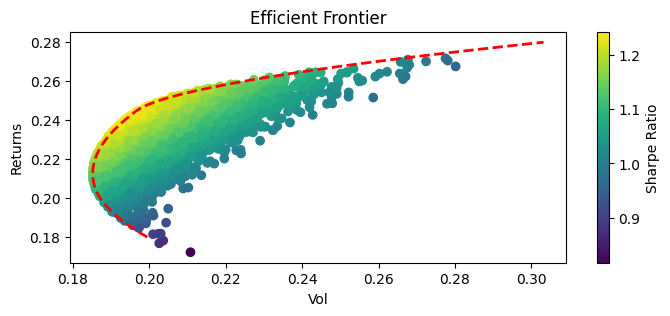

In [27]:
plt.figure(figsize=(8,3))
plt.scatter(monte_carlo_portfolio_vol, monte_carlo_portfolio_returns,c=monte_carlo_portfolio_sharpe_ratios)
plt.plot(frontier_vol, expected_returns_range, color = 'red', ls='--', lw=2)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Vol")
plt.ylabel("Returns")
plt.title("Efficient Frontier")

## Capital Asset Pricing Model (CAPM)

- Foundational financial model used to determine the expected return on an asset based on its systematic risk, as measured by its sensitivity to market movements.
- **Formula**
  -  The expected return of an asset: $E(R_{i}) = R_{f} + \beta_{i}(E(R_{m})-R_{f})$
- **Where**:
  - $E(R_{i})$ is the expected return on the asset/portfolio
  - $R_{f}$ is the risk-free rate
  - $\beta_{i}$ is the beta of the asset, a measure of an asset’s systematic risk relative to the overall market/index
  - $E(R_{m})$ is the expected return on the market/index
  - $(E(R_{m})-R_{f})$ is the market risk premium, the excess return expected from holding the asset/portfolio over a risk-free asset
- **beta** $\beta$
  - $\beta = \frac{\text{Cov}(R_{i},R_{m})}{\text{Var}(R_{m})}$
  - Given by the covariance of the asset’s return with the market return, divided by the variance of the market's return.
  - $\beta < 1$: Less volatile than the market/index, suggesting lower risk/returns.
  - $\beta > 1$: More volatile than the market, implying higher risk/returns.
  - $\beta = 1$: Moves in line with the market.
- **alpha** $\alpha$
  - $\alpha = R_{i} - [R_{f} + \beta_{i}(E(R_{m})-R_{f})]$
  - Represents the additional return (positive or negative) achieved over the expected return  of the market/index for a given level of risk.
  - $\alpha > 0$: Outperformed expectations, indicating potential skill or good asset selection.
  - $\alpha = 0$: In line with the expected return for the asset's risk level.
  - $\alpha < 0$: Underperformance, possibly due to poor asset selection or ineffective strategy.
- **Security Pricing**
  - *Fairly Valued*: If the asset's actual return aligns with its CAPM-derived expected return.
  - *Undervalued*: If the actual return is higher than the CAPM-predicted return (indicating a buying opportunity).
  - *Overvalued*: If the actual return is lower than the CAPM-predicted return (suggesting the asset may be overpriced).
- **Assumptions**
  - Efficient Market: All investors have the same information and rational expectations, meaning asset prices fully reflect all available information.
  - Single-Period Investment Horizon: CAPM assumes a single time period for investment returns, typically one year.
  - No Transaction Costs or Taxes: CAPM assumes there are no trading fees or taxes, allowing investors to freely buy and sell assets.
  - Risk-averse Investors: Investors prefer less risk for a given level of return, consistent with modern portfolio theory.
  - Diversified Portfolio: CAPM assumes investors hold well-diversified portfolios to eliminate unsystematic risk, so only systematic risk (market risk) matters.
- **Limitations**
  - Simplistic Assumptions: Real-world conditions often do not align with CAPM’s assumptions, such as ignoring taxes, transaction costs, and investor behaviour.
  - Single-Factor Model: CAPM only considers market risk ($\beta$), ignoring other risk factors that may impact returns (e.g., size, value, or momentum factors, as considered in multi-factor models like the Fama-French model).
  - Historical $\beta$: CAPM relies on historical $\beta$ values, which may not accurately predict future risk if the asset's volatility changes over time.
  - Market Efficiency: CAPM assumes all investors have equal access to information, which may not hold true in practice, potentially leading to mispricing.
- **Applications**
  - Portfolio Management: CAPM helps in understanding the trade-off between risk and return, allowing investors to construct portfolios that align with their risk tolerance.
  - Stock Valuation: Investors use CAPM to estimate a fair return for an asset, helping them determine if a stock is overvalued or undervalued.
  - Performance Evaluation: CAPM can assess the performance of fund managers by comparing the actual return to the expected return based on the portfolio’s $\beta$.
- **Security Market Line (SML)**
  - Graphical representation of CAPM, plotting the expected return of assets as a function of their $\beta$.
    - Y-axis: Expected return $E(R_{i})$
    - X-axis: $\beta$
  - Assets above the SML are considered undervalued, as they offer higher returns for their level of risk.
  - Assets below the SML are considered overvalued, as they offer lower returns for their level of risk.

In [28]:
aapl_df = pd.read_csv('../mock_data/AAPL.csv', index_col='Date', parse_dates=True)['2017-01-01':'2020-01-01']
sp500_df = pd.read_csv('../mock_data/GSPC.csv', index_col='Date', parse_dates=True)['2017-01-01':'2020-01-01']

In [29]:
def compute_cumulative_return(df, get_absolute=True):
    initial_price = df['Adj Close'].iloc[0]
    final_price = df['Adj Close'].iloc[-1]
    if get_absolute:
        return final_price - initial_price
    else:
        return 100 * (final_price - initial_price) / initial_price
    
compute_cumulative_return(aapl_df)

45.071196

In [30]:
def create_daily_returns(df):
    df['Daily Returns'] = df['Adj Close'].pct_change(1)
    return df.dropna()

def create_cumulative_absolute(df):
    df['Cumulative Absolute'] = df['Adj Close'] - df['Adj Close'].iloc[0]
    return df

def create_cumulative_pct_change(df):
    df['Percent Change'] = 100 * (df['Adj Close'] - df['Adj Close'].iloc[0]) / df['Adj Close'].iloc[0]
    return df

In [31]:
aapl_df = create_daily_returns(aapl_df)
aapl_df = create_cumulative_absolute(aapl_df)
aapl_df = create_cumulative_pct_change(aapl_df)
aapl_df

,Open,High,Low,Close,Adj Close,Volume,Daily Returns,Cumulative Absolute,Percent Change
Date,,,,,,,,,
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.341724,84472400,-0.001119,0.000000,0.000000
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.480770,88774400,0.005085,0.139046,0.508549
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.787130,127007600,0.011148,0.445406,1.629034
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.041647,134247600,0.009160,0.699923,2.559908
2017-01-10,29.692499,29.844999,29.575001,29.777500,28.069925,97848400,0.001008,0.728201,2.663332
...,...,...,...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,70.129517,48478800,0.000951,42.787793,156.492667
2019-12-26,71.205002,72.495003,71.175003,72.477501,71.520905,93121200,0.019840,44.179181,161.581548
2019-12-27,72.779999,73.492500,72.029999,72.449997,71.493759,146266000,-0.000380,44.152035,161.482264


In [32]:
sp500_df = create_daily_returns(sp500_df)
sp500_df = create_cumulative_absolute(sp500_df)
sp500_df = create_cumulative_pct_change(sp500_df)
sp500_df

,Open,High,Low,Close,Adj Close,Volume,Daily Returns,Cumulative Absolute,Percent Change
Date,,,,,,,,,
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3764890000,0.005722,0.000000,0.000000
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3761820000,-0.000771,-1.750000,-0.077067
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3339890000,0.003517,6.229980,0.274358
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3217610000,-0.003549,-1.850098,-0.081475
2017-01-10,2269.719971,2279.270020,2265.270020,2268.899902,2268.899902,3638790000,0.000000,-1.850098,-0.081475
...,...,...,...,...,...,...,...,...,...
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296540000,-0.000195,952.629883,41.952213
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000,0.005128,969.159912,42.680168
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000,0.000034,969.270020,42.685017


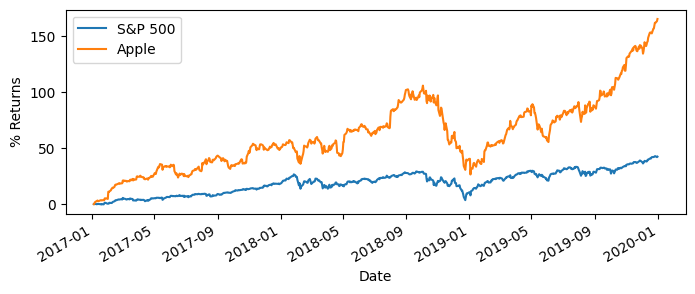

In [33]:
plt.figure(figsize=(8,3))
plt.ylabel("% Returns")
sp500_df['Percent Change'].plot(label="S&P 500")
aapl_df['Percent Change'].plot(label="Apple")
plt.legend()

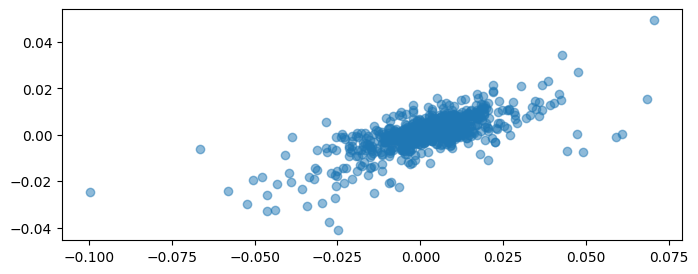

In [34]:
plt.figure(figsize=(8,3))
plt.scatter(aapl_df['Daily Returns'], sp500_df['Daily Returns'], alpha=0.5) # add alpha for transparency

In [ ]:
def beta_and_alpha_sp500(df):
    beta, alpha,_,_,_ = linregress(sp500_df['Daily Returns'], df['Daily Returns'])

    return beta, alpha

beta_and_alpha_sp500(sp500_df) # expect 1 and 0

(1.0, 0.0)

In [ ]:
beta_and_alpha_sp500(aapl_df) # AAPl outperformed the S&P 500

(1.3665697164904382, 0.00071941859186592)